In [1]:
#!/usr/bin/python
%matplotlib inline

import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#for mixed effects models
import statsmodels.api as sm
import statsmodels.formula.api as smf

import resource; resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots


In [2]:
#import data
clone_df=pd.read_excel('data/clone_abund_dbr.xlsx',sheetname=None)
reservoir_df=pd.read_excel('data/reservoir_size_dbr.xlsx')
Dvals=pd.read_excel('data/Dvals-dbr.xlsx')

HIV_ppts=reservoir_df['pid'].unique()
tART=reservoir_df['months']

In [3]:
#make a long HIV clone count dataframe
output_l=[]
for ppt in HIV_ppts:
    td=clone_df[str(ppt)]
    tART=list(reservoir_df[reservoir_df['pid']==ppt]['months'])
    for kt in range(2): #two time points each
        for Ci in range(len(td)): #clone index
            output_l.append([ppt,
                             Ci+1,
                             td['Hypermut'].iloc[Ci],
                             td['Intact (I) vs Defective (D)'].iloc[Ci],
                             td['Times seen in Timepoint '+str(kt+1)].iloc[Ci],
                             tART[kt]])
            
long_df=pd.DataFrame(output_l,columns=['pid','clone','hypermut','intact','counts','monthsART'])

In [4]:
pd.DataFrame.to_csv(long_df,'data/long_HIV.csv')
long_df


,pid,clone,hypermut,intact,counts,monthsART
0,548,1,N,I,1,16.6
1,548,2,H,D,1,16.6
2,548,3,N,D,0,16.6
3,548,4,N,D,0,16.6
4,548,5,N,D,0,16.6
5,548,6,N,D,0,16.6
6,548,7,N,D,0,16.6
7,548,8,N,D,0,16.6
8,548,9,H,D,0,16.6
9,548,10,N,D,0,16.6


In [5]:
#now make real summary df

summary_l=[]
for ppt in HIV_ppts:
    tdf=long_df[long_df['pid']==ppt]
    
    tpts=tdf['monthsART'].unique()
    for tpt in tpts:
        tdf2=tdf[tdf['monthsART']==tpt]
    
        N=np.sum(tdf2['counts'])
        maxcl=np.max(tdf2['counts'])
                     
        p_i = tdf2['counts']/N
        p_i = p_i[p_i>0] #drop zeros
        
        Robs=len(p_i)
        
        D1=np.exp(-np.sum(p_i*np.log(p_i)))
        D2=np.sum(p_i**2)**(-1)
        
        #intacts and defectives (remove whitespace)
        ID=tdf2['intact'].str.strip()
        IDr=np.sum(tdf2['counts'][ID=='D'])/np.sum(tdf2['counts']) #defective fraction
        
        #ratio of rank 2 to 1
        onetotwo=np.sort(-tdf2['counts'])[1]/np.sort(-tdf2['counts'])[0]

        #reservoir size
        IPDA=reservoir_df[(reservoir_df['pid']==ppt) & (reservoir_df['months']==tpt)]['meanIPDA'].iloc[0]
        totcells=reservoir_df[(reservoir_df['pid']==ppt) & (reservoir_df['months']==tpt)]['totalcells'].iloc[0]
        
        #add these all to the big list
        summary_l.append([ppt,tpt,N,
                          Robs,Robs/N,maxcl,maxcl/N,D1,D2,D1/N,D2/N,
                          IDr,onetotwo,np.log10(IPDA),np.log10(totcells)])

summary_df=pd.DataFrame(summary_l,columns=['pid','monthsART','N',
                                           'Robs','RobsN','maxcl','maxclN','D1','D2','D1N','D2N',
                                           'IDr','onetotwo','log10IPDA','log10totcells'])

pd.DataFrame.to_csv(summary_df,'data/summary_HIV.csv')

#double check not artifact from sample size
summary_df['iN']=1/summary_df['N']


In [6]:
#import the new summary_df that has Annie's additional rareified Ds
#summary_df = pd.read_csv('data/summary_HIV2.csv',index_col=False)

#drop the low sample size
#summary_df.drop(summary_df[summary_df['N']<30].index,inplace=True)

summary_df

,pid,monthsART,N,Robs,RobsN,maxcl,maxclN,D1,D2,D1N,D2N,IDr,onetotwo,log10IPDA,log10totcells,iN
0,548,16.6,10,10,1.000000,1,0.100000,10.000000,10.000000,1.000000,1.000000,0.900000,1.000000,3.860757,4.576834,0.100000
1,548,140.2,93,68,0.731183,4,0.043011,59.902321,51.177515,0.644111,0.550296,0.946237,1.000000,2.252229,3.199527,0.010753
2,1211,24.0,50,47,0.940000,2,0.040000,46.009383,44.642857,0.920188,0.892857,0.960000,1.000000,2.261104,3.613301,0.020000
3,1211,63.6,61,45,0.737705,17,0.278689,27.696050,11.174174,0.454034,0.183183,0.967213,0.058824,2.426782,3.599722,0.016393
4,746,22.2,86,85,0.988372,2,0.023256,84.624819,84.045455,0.984010,0.977273,0.860465,0.500000,2.722571,3.434202,0.011628
5,746,123.0,68,51,0.750000,15,0.220588,34.928001,16.167832,0.513647,0.237762,0.985294,0.200000,1.888193,3.174676,0.014706
6,583,22.4,54,53,0.981481,2,0.037037,52.631349,52.071429,0.974655,0.964286,0.962963,0.500000,2.695985,2.986405,0.018519
7,583,132.8,58,52,0.896552,6,0.103448,47.048875,37.377778,0.811188,0.644444,0.879310,0.333333,1.180413,2.772832,0.017241
8,22,24.0,48,36,0.750000,5,0.104167,30.079350,23.510204,0.626653,0.489796,0.895833,0.800000,2.747360,3.290632,0.020833
9,22,117.6,41,26,0.634146,7,0.170732,20.706772,15.422018,0.505043,0.376147,1.000000,0.571429,1.444045,3.058733,0.024390


In [7]:
#do an example mixed effects model    
md = smf.mixedlm('RobsN ~ monthsART', summary_df, groups=summary_df['pid'])
mdf = md.fit()
print(mdf.summary())

       Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: RobsN 
No. Observations: 10      Method:             REML  
No. Groups:       5       Scale:              0.0048
Min. group size:  2       Likelihood:         1.0026
Max. group size:  2       Converged:          Yes   
Mean group size:  2.0                               
----------------------------------------------------
          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------
Intercept  0.960    0.054 17.856 0.000  0.855  1.065
monthsART -0.002    0.000 -3.895 0.000 -0.003 -0.001
Group Var  0.007    0.142                           



/Applications/anaconda/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [8]:
#now check a bunch of MEM models, remove a few that didn't work
model_l=[]

big_pm_df=pd.DataFrame()
for indv in summary_df.columns[2:]:
    md = smf.mixedlm(indv+' ~ monthsART', summary_df, groups=summary_df['pid'])
    mdf = md.fit()

    if mdf.converged:
        pm_df = pd.DataFrame(mdf.params,columns=['estimate'])
        pm_df = pd.concat([pm_df,mdf.conf_int()],axis=1)#,ignore_index=True)
        pm_df['variable']=indv
        big_pm_df=pd.concat([big_pm_df,pm_df],axis=0)
        model_l.append(mdf)
        
    else:
        print(indv)

/Applications/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/Applications/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
/Applications/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Converge

N


/Applications/anaconda/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Applications/anaconda/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Applications/anaconda/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Applications/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying 

D1


/Applications/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/Applications/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
/Applications/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Converge

D2


/Applications/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/Applications/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)


IDr


/Applications/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2063: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Applications/anaconda/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2075: ConvergenceWarning: Gradient optimization failed, |grad| = 0.277081
  warnings.warn(msg, ConvergenceWarning)
/Applications/anaconda/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Applications/anaconda/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The

In [9]:
pd.DataFrame.to_csv(big_pm_df,'data/MEMresults.csv')

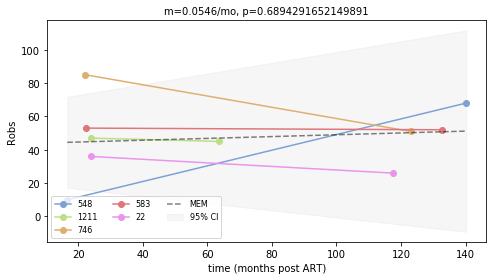

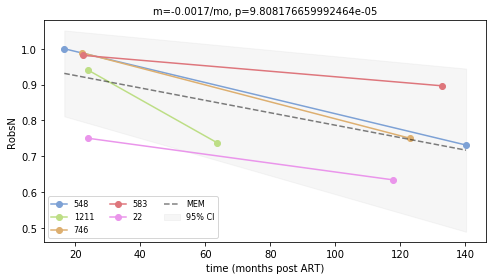

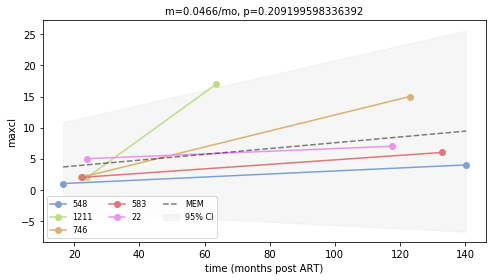

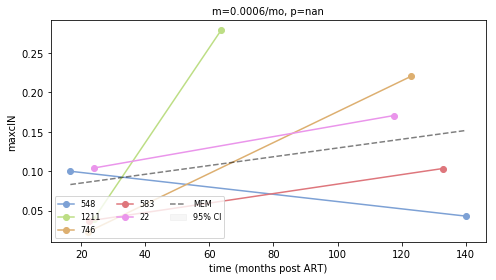

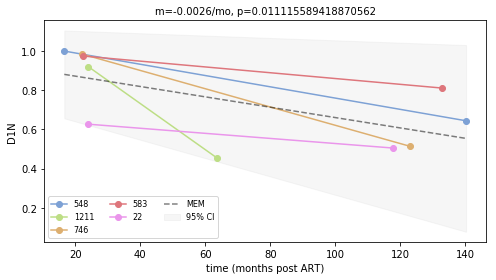

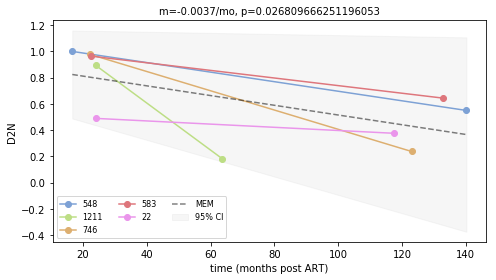

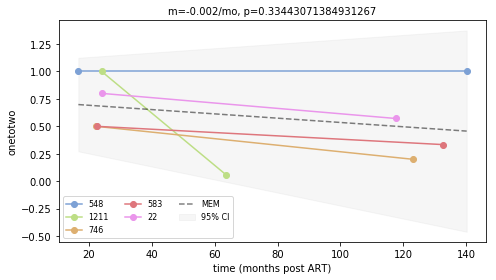

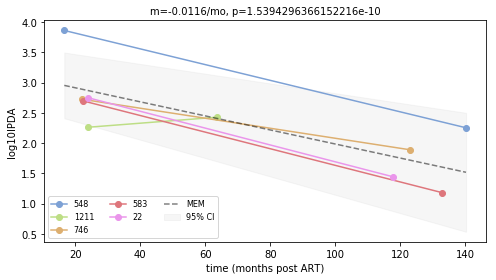

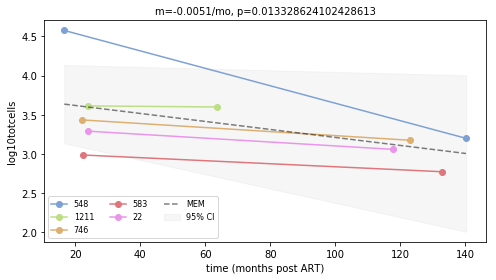

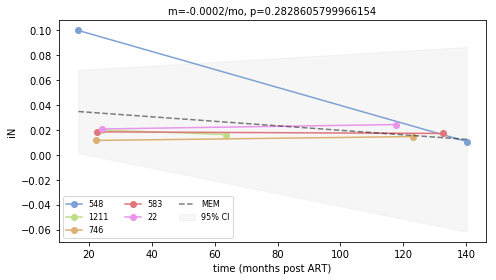

In [13]:
#plot MEM models that converged

#hcz=['skyblue','steelblue','navy','lightgreen','darkgreen'] #colors
    
#ppt 22,548,1211,583,746
hcz=['#7DA1D5','#BDDE85','#DDAF70','#DE767C','#EA95EB']
    
xmem=np.linspace(np.min(summary_df['monthsART']),np.max(summary_df['monthsART']),100)

annieout=[]
for vind, var in enumerate(big_pm_df['variable'].unique()):
    plt.figure(figsize=(7,4))
    
    #loop to plot data
    for pind, ppt in enumerate(HIV_ppts):
        tdf=summary_df[summary_df['pid']==ppt]
        plt.plot(tdf['monthsART'],tdf[var],c=hcz[pind],marker='o',label=ppt)

    #plot model results
    tdf3 = big_pm_df[big_pm_df['variable']==var] #select the variable
    
    mdf=model_l[vind]
    lz='m='+str(round(mdf.params[1],4))+'/mo, p='+str(mdf.pvalues[1])
    plt.plot(xmem,mdf.params[0]+mdf.params[1]*xmem,color='k',ls='--',label='MEM',alpha=0.5)

    plt.fill_between(xmem,
             mdf.conf_int().iloc[0,0]+mdf.conf_int().iloc[1,0]*xmem,
             mdf.conf_int().iloc[0,1]+mdf.conf_int().iloc[1,1]*xmem,color='lightgray',alpha=0.2,label='95% CI')
    
    plt.legend(ncol=3,loc=3,fontsize=8)
    plt.xlabel('time (months post ART)')
    plt.ylabel(var)
    #plt.ylim([min(summary_df[var])*0.8,max(summary_df[var])*1.2])
    plt.title(lz,fontsize=10)
    #plt.annotate(lz,[20,max(summary_df[var])*1.2])

    plt.tight_layout()
    plt.savefig('figures/MEM/'+var+'.pdf',dpi=600)
    
    
    annieout.append([var,mdf.params[0],mdf.params[1],mdf.pvalues[1],mdf.conf_int().iloc[1,0],mdf.conf_int().iloc[1,1]])

In [15]:
mdf.params

Intercept    3.787635e-02
monthsART   -1.810899e-04
Group Var    9.265681e-10
dtype: float64

In [11]:
annie_df=pd.DataFrame(annieout,columns=['variable','y0','slope_per_mo','pval','lower95_slope','upper95_slope'])

annie_df

,variable,y0,slope_per_mo,pval,lower95_slope,upper95_slope
0,Robs,43.554021,0.054574,6.894292e-01,-0.213083,0.322231
1,RobsN,0.959987,-0.001734,9.808177e-05,-0.002607,-0.000862
2,maxcl,2.899639,0.046625,2.091996e-01,-0.026146,0.119397
3,maxclN,0.073941,0.000556,NaN,NaN,NaN
4,D1N,0.924888,-0.002645,1.111559e-02,-0.004686,-0.000603
5,D2N,0.885742,-0.003702,2.680967e-02,-0.006980,-0.000425
6,onetotwo,0.730575,-0.001955,3.344307e-01,-0.005926,0.002015
7,log10IPDA,3.145559,-0.011620,1.539430e-10,-0.015178,-0.008062
8,log10totcells,3.721030,-0.005104,1.332862e-02,-0.009146,-0.001062
9,iN,0.037876,-0.000181,2.828606e-01,-0.000512,0.000149


In [16]:
annie_df['halflife_mo']=-np.log(2)/annie_df['slope_per_mo']
annie_df['faster95_halflife_mo']=-np.log(2)/annie_df['lower95_slope']

fastCI=np.array(-np.log(2)/annie_df['upper95_slope'])
fastCI[fastCI<0]=np.infty

annie_df['slower95_halflife_mo']=fastCI

pd.DataFrame.to_csv(annie_df,'annieMEMdf_withextra.csv')

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less


In [17]:
annie_df

,variable,y0,slope_per_mo,pval,lower95_slope,upper95_slope,halflife_mo,faster95_halflife_mo,slower95_halflife_mo
0,Robs,43.554021,0.054574,6.894292e-01,-0.213083,0.322231,-12.700984,3.252952,inf
1,RobsN,0.959987,-0.001734,9.808177e-05,-0.002607,-0.000862,399.665920,265.883344,804.420087
2,maxcl,2.899639,0.046625,2.091996e-01,-0.026146,0.119397,-14.866330,26.510686,inf
3,maxclN,0.073941,0.000556,NaN,NaN,NaN,-1247.054242,NaN,NaN
4,D1N,0.924888,-0.002645,1.111559e-02,-0.004686,-0.000603,262.085176,147.909445,1149.143331
5,D2N,0.885742,-0.003702,2.680967e-02,-0.006980,-0.000425,187.212228,99.309027,1630.032171
6,onetotwo,0.730575,-0.001955,3.344307e-01,-0.005926,0.002015,354.485572,116.969881,inf
7,log10IPDA,3.145559,-0.011620,1.539430e-10,-0.015178,-0.008062,59.649828,45.667504,85.972644
8,log10totcells,3.721030,-0.005104,1.332862e-02,-0.009146,-0.001062,135.802872,75.785070,652.733903
9,iN,0.037876,-0.000181,2.828606e-01,-0.000512,0.000149,3827.641827,1354.886960,inf
